In [1]:
import os
import random
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns

sns.set_style('ticks')
from pathlib import Path
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split         # Split data into train and test set

from utils import evaluate_classifier, get_sklearn_df 

# Automatically prints execution time for the individual cells
%load_ext autotime

# Automatically reloads functions defined in external files
%load_ext autoreload
%autoreload 2

# Set xarray to use html as display_style
xr.set_options(display_style="html")

# Tell matplotlib to plot directly in the notebook
%matplotlib inline  

# The path to the project (so absoute file paths can be used throughout the notebook)
PROJ_PATH = Path.cwd().parent

# Mapping dict
mapping_dict_crop_types = {
    'Kartofler, stivelses-': 'Potato',
    'Kartofler, lægge- (egen opformering)': 'Potato',
    'Kartofler, andre': 'Potato',
    'Kartofler, spise-': 'Potato',
    'Kartofler, lægge- (certificerede)': 'Potato',
    'Vårbyg': 'Spring barley',
    'Vinterbyg': 'Winter barley',
    'Vårhvede': 'Spring wheat',
    'Vinterhvede': 'Winter wheat',
    'Vinterrug': 'Winter rye',
    'Vårhavre': 'Spring oat',
    'Silomajs': 'Maize',
    'Vinterraps': 'Rapeseed',
    'Permanent græs, normalt udbytte': 'Permanent grass',
    'Pil': 'Willow',
    'Skovdrift, alm.': 'Forest'
}

# Set number of parallel jobs
N_JOBS = 24

# Set seed for random generators
RANDOM_SEED = 42

# Seed the random generators
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  # This is added back by InteractiveShellApp.init_path()


In [2]:
netcdf_path = (PROJ_PATH / 'data' / 'processed' / 'FieldPolygons2019_stats').with_suffix('.nc')
ds = xr.open_dataset(netcdf_path, engine="h5netcdf")
ds  # Remember to close the dataset before the netcdf file can be rewritten in cells above

<xarray.Dataset>
Dimensions:         (date: 77, field_id: 52769, polarization: 3)
Coordinates:
  * date            (date) datetime64[ns] 2018-07-08 2018-07-14 ... 2019-10-31
  * field_id        (field_id) int32 61853445 61952339 ... 67365067 67365062
  * polarization    (polarization) object 'VH' 'VV' 'VV-VH'
Data variables:
    afgkode         (field_id) int16 ...
    afgroede        (field_id) object ...
    cvr             (field_id) object ...
    gb              (field_id) float32 ...
    gbanmeldt       (field_id) float32 ...
    imk_areal       (field_id) float32 ...
    journalnr       (field_id) object ...
    marknr          (field_id) object ...
    pass_mode       (date) object ...
    relative_orbit  (date) int16 ...
    satellite       (date) object ...
    stats_max       (field_id, date, polarization) float32 ...
    stats_mean      (field_id, date, polarization) float32 ...
    stats_median    (field_id, date, polarization) float32 ...
    stats_min       (field_id, date, polarization) float32 ...
    stats_std       (field_id, date, polarization) float32 ...

time: 187 ms


In [3]:
ds.close()

time: 19.1 ms


In [4]:
# Convert the xarray dataset to pandas dataframe
df = ds.to_dataframe()
df = df.reset_index()  # Removes MultiIndex
df = df.drop(columns=['cvr', 'gb', 'gbanmeldt', 'journalnr', 'marknr', 'pass_mode', 'relative_orbit'])
df = df.dropna()

time: 8.95 s


In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression          
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

def get_classifiers(random_seed=42):
    # From https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
    # Note: GaussianClassifier does not work (maybe requires too much training - kernel restarts in jupyter)
    classifiers = { 
        #'Nearest Neighbors': GridSearchCV(KNeighborsClassifier(), 
        #                                  param_grid={'n_neighbors': [2, 4, 6, 8]}, 
        #                                  refit=True, cv=5, n_jobs=N_JOBS),
        'Decision Tree': GridSearchCV(DecisionTreeClassifier(random_state=random_seed, 
                                                             class_weight='balanced'), 
                                      param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 14, 16]}, 
                                      refit=True, cv=5, n_jobs=N_JOBS),
        'Random Forest': GridSearchCV(RandomForestClassifier(random_state=random_seed, 
                                                             class_weight='balanced'), 
                                      param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 14, 16], 
                                                  'n_estimators': [6, 8, 10, 12, 14], 
                                                  'max_features': [1, 2, 3]},
                                      refit=True, cv=5, n_jobs=N_JOBS),
        'Logistic Regression': GridSearchCV(LogisticRegression(max_iter=1000, random_state=random_seed, 
                                                               class_weight='balanced'),
                                            param_grid={'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2],
                                                        'penalty': ['none', 'l2']},
                                            refit=True, cv=5, n_jobs=N_JOBS),
        'Linear SVM': GridSearchCV(SVC(kernel='linear', random_state=random_seed, 
                                       class_weight='balanced'),
                                   #param_grid={'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]},
                                   param_grid={'C': [1e-2, 1e-1, 1]},
                                   refit=True, cv=5, n_jobs=N_JOBS),
        'RBF SVM': GridSearchCV(SVC(kernel='rbf', random_state=random_seed, 
                                    class_weight='balanced'),
                                #param_grid={'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]},
                                param_grid={'C': [1e-2, 1e-1, 1]},
                                refit=True, cv=5, n_jobs=N_JOBS),
        'Neural Network': GridSearchCV(MLPClassifier(max_iter=1000, random_state=random_seed),
                                       param_grid={'alpha': [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2],
                                                   'hidden_layer_sizes': [(50,50,50), (100,)],
                                                   'activation': ['relu'],
                                                   'learning_rate': ['constant']},
                                       refit=True, cv=5, n_jobs=N_JOBS)
        }
    
    return classifiers

time: 215 ms


In [7]:
def remap_df(df_sklearn):
    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
    
    return df_sklearn_remapped, class_names

time: 20.9 ms


In [8]:
df_clf_results = pd.DataFrame(columns=['Classifier', 'Date', 'Crop type', 'Prec.', 'Recall', 
                                       'F1-Score', 'Accuracy', 'Samples', 'Random seed'])

for random_seed in range(10):
    print(f"\n\n########################## RANDOM SEED IS SET TO {random_seed:2d} ##########################") 
    # Seed the random generators
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)

    # Get classifiers
    classifiers = get_classifiers(random_seed)
    
    # Add an extra month to the date range at each iteration in the loop
    year = 2018
    for i in range(7, 24, 1):
        month = (i % 12) + 1
        if month == 1:
            year += 1

        end_date = f'{year}-{month:02}-01'

        print(f"\n#########################################")
        print(f"# Dataset from 2018-07-01 to {end_date} #")
        print(f"#########################################\n")
        df_sklearn = get_sklearn_df(polygons_year=2019, 
                                    satellite_dates=slice('2018-07-01', f'{end_date}'), 
                                    fields='all', 
                                    satellite='all', 
                                    polarization='all',
                                    crop_type='all',
                                    netcdf_path=netcdf_path)

        df_sklearn_remapped, class_names = remap_df(df_sklearn)

        # Get values as numpy array
        array = df_sklearn_remapped.values
        X = np.float32(array[:,5:])  # The features 
        y = np.int8(array[:,4])  # The column 'afgkode'
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, shuffle=True, 
                                                            random_state=random_seed)

        for name, clf in classifiers.items():
            # Evaluate classifier
            print("-------------------------------------------------------------------------------")
            print(f"Evaluating classifier: {name}")
            clf_trained, _, _, results_report, cnf_matrix = evaluate_classifier(
                clf, X_train, X_test, y_train, y_test, class_names, feature_scale=True, plot_conf_matrix=False,
                print_classification_report=False)      
            print(f"The best parameters are {clf_trained.best_params_} (score = {clf_trained.best_score_:2f})")

            # Save results for individual crops in df
            df_results = pd.DataFrame(results_report).transpose()  
            for crop_type in class_names:
                # Get values
                prec = df_results.loc[crop_type, 'precision']
                recall = df_results.loc[crop_type, 'recall']
                f1 = df_results.loc[crop_type, 'f1-score']
                samples = df_results.loc[crop_type, 'support']
                acc = None

                # Insert row in df (https://stackoverflow.com/a/24284680/12045808)
                df_clf_results.loc[-1] = [name, end_date, crop_type, prec, recall, f1, acc, samples, 
                                          random_seed]
                df_clf_results.index = df_clf_results.index + 1  # shifting index
                df_clf_results = df_clf_results.sort_index()  # sorting by index

            # Save overall results
            prec = df_results.loc['weighted avg', 'precision']
            recall = df_results.loc['weighted avg', 'recall']
            f1 = df_results.loc['weighted avg', 'f1-score']
            acc = df_results.loc['accuracy', 'f1-score']
            samples = df_results.loc['weighted avg', 'support']

            # Insert row in df (https://stackoverflow.com/a/24284680/12045808)
            df_clf_results.loc[-1] = [name, end_date, 'Overall', prec, recall, f1, acc, samples, 
                                      random_seed]
            df_clf_results.index = df_clf_results.index + 1  # shifting index
            df_clf_results = df_clf_results.sort_index()  # sorting by index
    
            # Save df with results to disk
            save_path = PROJ_PATH / 'notebooks' / '04_ClassifyDuringSeason_results.pkl'
            df_clf_results.to_pickle(save_path)



################################## RANDOM SEED IS SET TO  0 ##################################

#########################################
# Dataset from 2018-07-01 to 2018-08-01 #
#########################################

-------------------------------------------------------------------------------
Evaluating classifier: Decision Tree
Training time: 3.4283 s
Prediction time: 0.0021 s

Report:

Train accuracy: 0.3072
Test accuracy: 0.2748
The best parameters are {'max_depth': 8} with a score of 0.279460
-------------------------------------------------------------------------------
Evaluating classifier: Random Forest
Training time: 13.1653 s
Prediction time: 0.0261 s

Report:

Train accuracy: 0.5169
Test accuracy: 0.3198
The best parameters are {'max_depth': 12, 'max_features': 3, 'n_estimators': 14} with a score of 0.322467
-------------------------------------------------------------------------------
Evaluating classifier: Logistic Regression


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Training time: 40.1922 s
Prediction time: 0.0019 s

Report:

Train accuracy: 0.2842
Test accuracy: 0.2783
The best parameters are {'C': 0.0001, 'penalty': 'none'} with a score of 0.281355
-------------------------------------------------------------------------------
Evaluating classifier: Linear SVM
Training time: 105.947 s
Prediction time: 8.2553 s

Report:

Train accuracy: 0.3056
Test accuracy: 0.2952
The best parameters are {'C': 0.1} with a score of 0.302746
-------------------------------------------------------------------------------
Evaluating classifier: RBF SVM
Training time: 142.0037 s
Prediction time: 13.618 s

Report:

Train accuracy: 0.3521
Test accuracy: 0.332
The best parameters are {'C': 1} with a score of 0.333483
-------------------------------------------------------------------------------
Evaluating classifier: Neural Network
Training time: 166.12 s
Prediction time: 0.0123 s

Report:

Train accuracy: 0.374
Test accuracy: 0.3509
The best parameters are {'activatio

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Training time: 112.3257 s
Prediction time: 0.0039 s

Report:

Train accuracy: 0.5415
Test accuracy: 0.5379
The best parameters are {'C': 1, 'penalty': 'l2'} with a score of 0.534679
-------------------------------------------------------------------------------
Evaluating classifier: Linear SVM
Training time: 233.8064 s
Prediction time: 23.8494 s

Report:

Train accuracy: 0.5532
Test accuracy: 0.5472
The best parameters are {'C': 0.01} with a score of 0.544178
-------------------------------------------------------------------------------
Evaluating classifier: RBF SVM
Training time: 307.5606 s
Prediction time: 31.8484 s

Report:

Train accuracy: 0.6772
Test accuracy: 0.616
The best parameters are {'C': 1} with a score of 0.608224
-------------------------------------------------------------------------------
Evaluating classifier: Neural Network
Training time: 154.0547 s
Prediction time: 0.0151 s

Report:

Train accuracy: 0.6391
Test accuracy: 0.6095
The best parameters are {'activati

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Training time: 41.7455 s
Prediction time: 0.0016 s

Report:

Train accuracy: 0.2824
Test accuracy: 0.2807
The best parameters are {'C': 0.0001, 'penalty': 'none'} with a score of 0.280745
-------------------------------------------------------------------------------
Evaluating classifier: Linear SVM
Training time: 104.3704 s
Prediction time: 8.2638 s

Report:

Train accuracy: 0.3021
Test accuracy: 0.2998
The best parameters are {'C': 0.1} with a score of 0.301012
-------------------------------------------------------------------------------
Evaluating classifier: RBF SVM
Training time: 141.0269 s
Prediction time: 13.6203 s

Report:

Train accuracy: 0.3488
Test accuracy: 0.3351
The best parameters are {'C': 1} with a score of 0.329982
-------------------------------------------------------------------------------
Evaluating classifier: Neural Network
Training time: 189.9748 s
Prediction time: 0.0124 s

Report:

Train accuracy: 0.3677
Test accuracy: 0.3545
The best parameters are {'act

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-------------------------------------------------------------------------------
Evaluating classifier: Decision Tree
Training time: 2.7279 s
Prediction time: 0.0018 s

Report:

Train accuracy: 0.3416
Test accuracy: 0.3145
The best parameters are {'max_depth': 8} with a score of 0.316076
-------------------------------------------------------------------------------
Evaluating classifier: Random Forest
Training time: 13.2739 s
Prediction time: 0.032 s

Report:

Train accuracy: 0.7445
Test accuracy: 0.3759
The best parameters are {'max_depth': 14, 'max_features': 3, 'n_estimators': 14} with a score of 0.374088
-------------------------------------------------------------------------------
Evaluating classifier: Logistic Regression
Training time: 57.1314 s
Prediction time: 0.0017 s

Report:

Train accuracy: 0.3424
Test accuracy: 0.3427
The best parameters are {'C': 1, 'penalty': 'l2'} with a score of 0.339712
-------------------------------------------------------------------------------


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-------------------------------------------------------------------------------
Evaluating classifier: Decision Tree
Training time: 5.5454 s
Prediction time: 0.0025 s

Report:

Train accuracy: 0.5864
Test accuracy: 0.4387
The best parameters are {'max_depth': 12} with a score of 0.440528
-------------------------------------------------------------------------------
Evaluating classifier: Random Forest
Training time: 13.7249 s
Prediction time: 0.0338 s

Report:

Train accuracy: 0.887
Test accuracy: 0.5136
The best parameters are {'max_depth': 16, 'max_features': 3, 'n_estimators': 14} with a score of 0.514244
-------------------------------------------------------------------------------
Evaluating classifier: Logistic Regression
Training time: 93.6482 s
Prediction time: 0.0021 s

Report:

Train accuracy: 0.5047
Test accuracy: 0.4949
The best parameters are {'C': 0.01, 'penalty': 'l2'} with a score of 0.500499
----------------------------------------------------------------------------

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-------------------------------------------------------------------------------
Evaluating classifier: Decision Tree
Training time: 2.7367 s
Prediction time: 0.002 s

Report:

Train accuracy: 0.4014
Test accuracy: 0.3267
The best parameters are {'max_depth': 10} with a score of 0.318713
-------------------------------------------------------------------------------
Evaluating classifier: Random Forest
Training time: 13.236 s
Prediction time: 0.0283 s

Report:

Train accuracy: 0.5961
Test accuracy: 0.3742
The best parameters are {'max_depth': 12, 'max_features': 3, 'n_estimators': 14} with a score of 0.374763
-------------------------------------------------------------------------------
Evaluating classifier: Logistic Regression


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Training time: 54.1252 s
Prediction time: 0.0016 s

Report:

Train accuracy: 0.3418
Test accuracy: 0.3399
The best parameters are {'C': 0.01, 'penalty': 'l2'} with a score of 0.338521
-------------------------------------------------------------------------------
Evaluating classifier: Linear SVM
Training time: 156.8801 s
Prediction time: 11.5433 s

Report:

Train accuracy: 0.3559
Test accuracy: 0.3555
The best parameters are {'C': 0.01} with a score of 0.352446
-------------------------------------------------------------------------------
Evaluating classifier: RBF SVM
Training time: 192.6007 s
Prediction time: 18.2821 s

Report:

Train accuracy: 0.4552
Test accuracy: 0.4118
The best parameters are {'C': 1} with a score of 0.409236
-------------------------------------------------------------------------------
Evaluating classifier: Neural Network
Training time: 163.216 s
Prediction time: 0.0138 s

Report:

Train accuracy: 0.4585
Test accuracy: 0.4235
The best parameters are {'activa

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Training time: 151.3532 s
Prediction time: 0.0076 s

Report:

Train accuracy: 0.8895
Test accuracy: 0.8718
The best parameters are {'C': 0.1, 'penalty': 'l2'} with a score of 0.878411
-------------------------------------------------------------------------------
Evaluating classifier: Linear SVM
Training time: 127.1914 s
Prediction time: 21.9575 s

Report:

Train accuracy: 0.8981
Test accuracy: 0.8839
The best parameters are {'C': 0.01} with a score of 0.886433
-------------------------------------------------------------------------------
Evaluating classifier: RBF SVM
Training time: 360.3411 s
Prediction time: 31.5907 s

Report:

Train accuracy: 0.9431
Test accuracy: 0.9045
The best parameters are {'C': 1} with a score of 0.904604
-------------------------------------------------------------------------------
Evaluating classifier: Neural Network
Training time: 144.2116 s
Prediction time: 0.0181 s

Report:

Train accuracy: 0.9179
Test accuracy: 0.9022
The best parameters are {'activ

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-------------------------------------------------------------------------------
Evaluating classifier: Decision Tree
Training time: 2.8355 s
Prediction time: 0.002 s

Report:

Train accuracy: 0.3971
Test accuracy: 0.3167
The best parameters are {'max_depth': 10} with a score of 0.316236
-------------------------------------------------------------------------------
Evaluating classifier: Random Forest
Training time: 13.2271 s
Prediction time: 0.0279 s

Report:

Train accuracy: 0.5966
Test accuracy: 0.3779
The best parameters are {'max_depth': 12, 'max_features': 3, 'n_estimators': 14} with a score of 0.374281
-------------------------------------------------------------------------------
Evaluating classifier: Logistic Regression
Training time: 56.2436 s
Prediction time: 0.0016 s

Report:

Train accuracy: 0.3404
Test accuracy: 0.342
The best parameters are {'C': 0.01, 'penalty': 'l2'} with a score of 0.339229
-----------------------------------------------------------------------------

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training time: 115.1577 s
Prediction time: 0.0027 s

Report:

Train accuracy: 0.5284
Test accuracy: 0.5182
The best parameters are {'C': 10.0, 'penalty': 'l2'} with a score of 0.521457
-------------------------------------------------------------------------------
Evaluating classifier: Linear SVM
Training time: 248.5257 s
Prediction time: 17.9955 s

Report:

Train accuracy: 0.5389
Test accuracy: 0.5253
The best parameters are {'C': 1} with a score of 0.528378
-------------------------------------------------------------------------------
Evaluating classifier: RBF SVM
Training time: 261.4589 s
Prediction time: 27.2627 s

Report:

Train accuracy: 0.6496
Test accuracy: 0.5934
The best parameters are {'C': 1} with a score of 0.585262
-------------------------------------------------------------------------------
Evaluating classifier: Neural Network
Training time: 164.4594 s
Prediction time: 0.0136 s

Report:

Train accuracy: 0.6669
Test accuracy: 0.6012
The best parameters are {'activat

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training time: 121.9165 s
Prediction time: 0.003 s

Report:

Train accuracy: 0.5458
Test accuracy: 0.5406
The best parameters are {'C': 10.0, 'penalty': 'l2'} with a score of 0.536450
-------------------------------------------------------------------------------
Evaluating classifier: Linear SVM
Training time: 243.5464 s
Prediction time: 22.1312 s

Report:

Train accuracy: 0.5574
Test accuracy: 0.5497
The best parameters are {'C': 0.1} with a score of 0.546046
-------------------------------------------------------------------------------
Evaluating classifier: RBF SVM
Training time: 314.2726 s
Prediction time: 31.1783 s

Report:

Train accuracy: 0.6768
Test accuracy: 0.6184
The best parameters are {'C': 1} with a score of 0.606131
-------------------------------------------------------------------------------
Evaluating classifier: Neural Network
Training time: 163.2346 s
Prediction time: 0.0143 s

Report:

Train accuracy: 0.7009
Test accuracy: 0.6217
The best parameters are {'activa

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



#########################################
# Dataset from 2018-07-01 to 2018-11-01 #
#########################################

-------------------------------------------------------------------------------
Evaluating classifier: Decision Tree
Training time: 5.4422 s
Prediction time: 0.0024 s

Report:

Train accuracy: 0.5938
Test accuracy: 0.4543
The best parameters are {'max_depth': 12} with a score of 0.438822
-------------------------------------------------------------------------------
Evaluating classifier: Random Forest
Training time: 13.3132 s
Prediction time: 0.0359 s

Report:

Train accuracy: 0.8906
Test accuracy: 0.5095
The best parameters are {'max_depth': 16, 'max_features': 2, 'n_estimators': 14} with a score of 0.507130
-------------------------------------------------------------------------------
Evaluating classifier: Logistic Regression
Training time: 92.7501 s
Prediction time: 0.0022 s

Report:

Train accuracy: 0.4998
Test accuracy: 0.5028
The best parameters are {

In [14]:
# Load the df with results from saved file
load_path = PROJ_PATH / 'notebooks' / '04_ClassifyDuringSeason_results.pkl'
df_clf_results = pd.read_pickle(load_path)

time: 39.8 ms


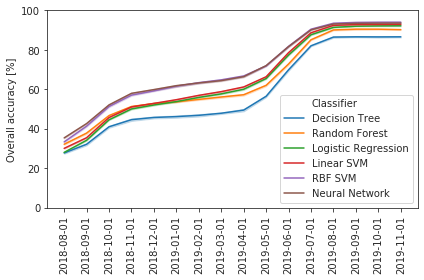

time: 535 ms


In [40]:
# If you loop over random seeds, the confidence interval can be made just by setting ci='std'
df_overall = df_clf_results[df_clf_results['Crop type'] == 'Overall'].astype({'Accuracy': 'float64'})
# I made an error. 2019-11-01 should have been the last date, so remove 2019-12-01.
df_overall = df_overall[df_overall['Date'] != '2019-12-01']  
df_overall['Accuracy'] = df_overall['Accuracy'] * 100

# Plot
#plt.figure(figsize=(20,8)) 
ax = sns.lineplot(x="Date", y="Accuracy", hue='Classifier', ci='sd', 
                  data=df_overall.sort_index(ascending=False))
ax.set_ylabel('Overall accuracy [%]')
ax.set_xlabel('')
ax.set_ylim(0, 100) 
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    
save_path = PROJ_PATH / 'reports' / 'figures' / 'ClassifierDuringSeason.pdf'
fig = ax.get_figure()
fig.tight_layout()
fig.savefig(save_path)

In [11]:
df_overall[df_overall['Classifier']=='Decision Tree']

,Classifier,Date,Crop type,Prec.,Recall,F1-Score,Accuracy,Samples,Random seed
65,Decision Tree,2019-12-01,Overall,0.876350,0.870526,0.872785,0.870526,13300.0,9
143,Decision Tree,2019-11-01,Overall,0.876350,0.870526,0.872785,0.870526,13300.0,9
221,Decision Tree,2019-10-01,Overall,0.874906,0.868281,0.870745,0.868281,13301.0,9
299,Decision Tree,2019-09-01,Overall,0.872538,0.866852,0.868954,0.866852,13301.0,9
377,Decision Tree,2019-08-01,Overall,0.875552,0.869117,0.871426,0.869117,13302.0,9
...,...,...,...,...,...,...,...,...,...
12935,Decision Tree,2018-12-01,Overall,0.473354,0.449677,0.448735,0.449677,13314.0,0
13013,Decision Tree,2018-11-01,Overall,0.457511,0.442166,0.439414,0.442166,13314.0,0
13091,Decision Tree,2018-10-01,Overall,0.414563,0.411005,0.398605,0.411005,13321.0,0
13169,Decision Tree,2018-09-01,Overall,0.322070,0.322929,0.302168,0.322929,13328.0,0


time: 36.1 ms


In [16]:
df_overall.groupby(['Classifier', 'Date'])['Accuracy'].mean().to_frame()

# NOTE: Take a look at below on how to get min and max values
# See https://stackoverflow.com/a/46501773/12045808
#df = (df.assign(Data_Value=df['Data_Value'].abs())
#       .groupby(['Day'])['Data_Value'].agg([('Min' , 'min'), ('Max', 'max')])
#       .add_prefix('Day'))

Accuracy
Classifier    Date                
Decision Tree 2018-08-01  0.276851
              2018-09-01  0.321016
              2018-10-01  0.409714
              2018-11-01  0.445734
              2018-12-01  0.457015
...                            ...
Random Forest 2019-08-01  0.900970
              2019-09-01  0.904812
              2019-10-01  0.904669
              2019-11-01  0.902594
              2019-12-01  0.902594

[102 rows x 1 columns]

time: 46.7 ms


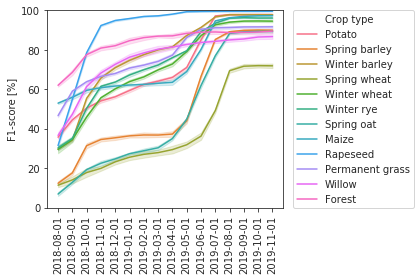

time: 744 ms


In [39]:
# Select classifier to plot
df_crop = df_clf_results[df_clf_results['Classifier'] == 'RBF SVM']
df_crop = df_crop[df_crop['Date'] != '2019-12-01']  # Made an error (2019-11-01 is actually the last date)
df_crop['F1-Score'] = df_crop['F1-Score'] * 100

# Drop the 'Overall' results and only use the individual crop types
df_crop = df_crop[df_crop['Crop type'] != 'Overall']

#Plot
#plt.figure(figsize=(20,8)) 
# Define markers 
# Note: Markers are not working in lineplots 
# (see https://github.com/mwaskom/seaborn/issues/1513#issuecomment-480261748)
filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D')
# Take a look at:
# https://seaborn.pydata.org/tutorial/relational.html#relational-tutorial
# and
# https://seaborn.pydata.org/generated/seaborn.lineplot.html

ax = sns.lineplot(x="Date", y="F1-Score", hue='Crop type', data=df_crop.sort_index(ascending=False), ci='sd')
ax.set_ylabel('F1-score [%]')
ax.set_xlabel('')
ax.set_ylim(0, 100)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    
ax.legend(bbox_to_anchor=(1.04, 1.0), loc=2, borderaxespad=0.)
#ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)

save_path = PROJ_PATH / 'reports' / 'figures' / 'ClassifierDuringSeasonCrop.pdf'
fig = ax.get_figure()
fig.tight_layout()
fig.savefig(save_path)